# Amadeus v1 - Music Genre Classification

## Import Libraries and Data

In [69]:
from keras import models, layers
import librosa 
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import random
import sklearn
import csv
import keras
import pandas as pd

In [40]:
raw_data = np.genfromtxt('database.csv', delimiter=',', dtype=None, encoding='UTF8')

## Load Example Genre

Genres:
* Classical
* Country
* Disco
* Hiphop
* Jazz
* Rock
* Blues
* Reggae
* Pop
* Metal

In [41]:
genre = 'Classical'

mapping = {
    'Classical': 0,
    'Country': 100,
    'Disco': 200,
    'Hiphop': 300,
    'Jazz': 400,
    'Rock': 500,
    'Blues': 600,
    'Reggae': 700,
    'Pop': 800,
    'Metal': 900
}

index = random.randint(mapping[genre], mapping[genre]+99)
print(genre, ":", index)
    
ex = raw_data[index][0]
data, sr = librosa.load(ex, mono=True, duration=30)
ipd.Audio(ex)

Classical : 35


## Extract Features From Example

Selected Features:
* Zero Crossings
* Spectral Centroid
* Spectral Rolloff
* Mel-Frequency Cepstral Coefficients

In [42]:
zero_crossings = librosa.feature.zero_crossing_rate(data, pad=False)
print(np.mean(zero_crossings))

0.06115495900251548


1016.2794101985547


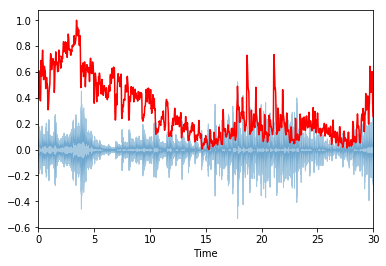

In [43]:
spectral_centroids = librosa.feature.spectral_centroid(data, sr=sr)[0]
print(np.mean(spectral_centroids))
t = librosa.frames_to_time(range(len(spectral_centroids)))
librosa.display.waveplot(data, sr=sr, alpha=0.4)
plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_centroids), color='r')

1480.8827119715074


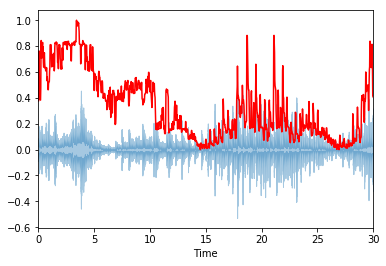

In [44]:
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.05, sr=sr)[0]
print(np.mean(spectral_rolloff))
librosa.display.waveplot(data, sr=sr, alpha=0.4)
plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_rolloff), color='r')

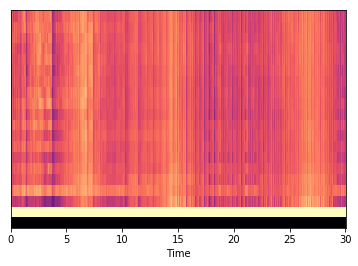

In [45]:
mfccs = librosa.feature.mfcc(data, sr=sr)
librosa.display.specshow(sklearn.preprocessing.minmax_scale(mfccs), sr=sr, x_axis='time')

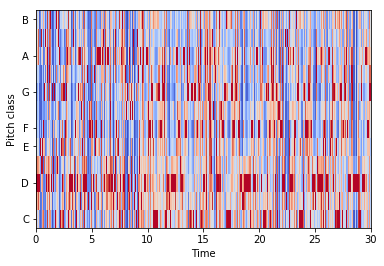

In [48]:
chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

## Create Dataset of Features from Song Database

In [57]:
# Split dataset into 80% for training and 20% for testing. Use features mentioned above. 
print("Extracting features from song database. This might take a while.")
num_songs = 1000

encoding = {
    0: 'Classical',
    1: 'Country',
    2: 'Disco',
    3: 'Hiphop',
    4: 'Jazz',
    5: 'Rock',
    6: 'Blues',
    7: 'Reggae',
    8: 'Pop',
    9: 'Metal'
}

with open('train.csv', 'w') as a, open('test.csv', 'w') as b:
    train = csv.writer(a)
    test = csv.writer(b)
    
    header = ['Zero Crossing', 'Spectral Centroids', 'Spectral Rolloff', 'Chromagram']
    for i in range(20):
        header.append('MFCC '+str(i))
    header.append('Genre')
    
    train.writerow(header)
    test.writerow(header)
    
    for i in range(num_songs):
        ex = raw_data[i][0]
        data, sr = librosa.load(ex, mono=True, duration=30)
    
        zero_crossings = librosa.feature.zero_crossing_rate(data, pad=False)
        spectral_centroids = librosa.feature.spectral_centroid(data, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(data+0.05, sr=sr)[0]
        mfccs = librosa.feature.mfcc(data, sr=sr)
        chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512)
        
        row = []
        row.append(np.mean(zero_crossings))
        row.append(np.mean(spectral_centroids))
        row.append(np.mean(spectral_rolloff))
        row.append(np.mean(chromagram))
        for j in range(20):
            row.append(np.mean(mfccs[j]))
        row.append(encoding[i//100])
        
        if i % 100 < 80:
            train.writerow(row)
        else:
            test.writerow(row)
        
        if i % 100 == 99:
            print("Finished", str((i//100+1)*10)+'%', 'of music feature extraction for dataset.')

Extracting features from song database. This might take a while.
Finished 10% of music feature extraction for dataset.
Finished 20% of music feature extraction for dataset.
Finished 30% of music feature extraction for dataset.
Finished 40% of music feature extraction for dataset.
Finished 50% of music feature extraction for dataset.
Finished 60% of music feature extraction for dataset.
Finished 70% of music feature extraction for dataset.
Finished 80% of music feature extraction for dataset.
Finished 90% of music feature extraction for dataset.
Finished 100% of music feature extraction for dataset.


## Create the Keras Model

In [125]:
data = pd.read_csv('train.csv').values
encoder = sklearn.preprocessing.LabelEncoder()
Y = encoder.fit_transform(data[:, -1:].ravel())
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(data[:, :-1])

In [219]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [220]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [229]:
result = model.fit(X, Y, epochs=25, batch_size=128)

Epoch 1/25
800/800 [==============================] - 0s 53us/step - loss: 0.0177 - accuracy: 0.9975
Epoch 2/25
800/800 [==============================] - 0s 46us/step - loss: 0.0151 - accuracy: 0.9987
Epoch 3/25
800/800 [==============================] - 0s 52us/step - loss: 0.0148 - accuracy: 0.9987
Epoch 4/25
800/800 [==============================] - 0s 51us/step - loss: 0.0134 - accuracy: 0.9987
Epoch 5/25
800/800 [==============================] - 0s 42us/step - loss: 0.0107 - accuracy: 0.9987
Epoch 6/25
800/800 [==============================] - 0s 55us/step - loss: 0.0126 - accuracy: 0.9987
Epoch 7/25
800/800 [==============================] - 0s 53us/step - loss: 0.0101 - accuracy: 0.9987
Epoch 8/25
800/800 [==============================] - 0s 42us/step - loss: 0.0123 - accuracy: 0.9975
Epoch 9/25
800/800 [==============================] - 0s 43us/step - loss: 0.0095 - accuracy: 0.9987
Epoch 10/25
800/800 [==============================] - 0s 34us/step - loss: 0.0120 - accura

## Evaluate the Model

In [230]:
test_data = pd.read_csv('test.csv').values
Y_test = encoder.fit_transform(test_data[:, -1:].ravel())
X_test = scaler.fit_transform(test_data[:, :-1])

In [231]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

200/200 [==============================] - 0s 176us/step


In [232]:
print(test_acc)

0.5099999904632568
